October: This notebook extracts the realistic bathymetry of the domain.

In [103]:
import numpy as np
import netCDF4 as nc
import os
import scipy as sc, scipy.io
from pyproj import Proj, Geod, transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colormap_ibcao
%matplotlib inline

# Get domain coordinates

In [104]:
filename = 'coords_mack06.nc'
coord_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/tests_coordinates/'+filename)
lon = coord_file['nav_lon']
lat = coord_file['nav_lat']

def convert_corners(proj_from, proj_to, corner_lons, corner_lats):
    ''' Converts the coordinates of the domain corner points
    from the projection proj_from to the projection proj_to.
    The tranformed coordinates are returned.
    '''
    transformed_lons = []
    transformed_lats = []
    for i in np.arange(len(corner_lons)):
        transformed_x, transformed_y = transform(proj_from, proj_to, corner_lons[i], corner_lats[i])
        transformed_lons.append(transformed_x)
        transformed_lats.append(transformed_y)
    return transformed_lons, transformed_lats

# -----------------------------------------------------------------------------------------------
#lon_geogr = [lon[-1,0], lon[0,0], lon[0,-1], lon[-1,-1]]
#lat_geogr = [lat[-1,0], lat[0,0], lat[0,-1], lat[-1,-1]]

proj_geogr = Proj("+init=EPSG:4326") # Geographical coordinate system
proj_stere = Proj("+init=EPSG:3996") # IBCAO polar stereographic

#lon_stere0, lat_stere0 = convert_corners(proj_geogr, proj_stere, lon_geogr, lat_geogr)
#lon_stere = [round(float(x) / 500) * 500 for x in lon_stere0]
#lat_stere = [round(float(x) / 500) * 500 for x in lat_stere0]
#lonBR = lon_stere[0]; lonTR = lon_stere[1]; lonTL = lon_stere[2]; lonBL = lon_stere[3]
#latBR = lat_stere[0]; latTR = lat_stere[1]; latTL = lat_stere[2]; latBL = lat_stere[3]
#print(min(lon_stere0), lat_stere0)

# -----------------------------------------------------------------------------------------------
lons_canyon =  np.zeros_like(lon)
lats_canyon =  np.zeros_like(lat)
for i in np.arange(lon.shape[0]):
    lons_canyon[i,:], lats_canyon[i,:] = transform(proj_geogr, proj_stere, lon[i,:], lat[i,:])

# Get IBCAO bathymetry

In [4]:
bathy_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x = bathy_file.variables['x'][:]
y = bathy_file.variables['y'][:]
z = bathy_file.variables['z'][:]

xl=-1750e3; xr=-1050e3; yb=1300e3; yt=2000e3
xmin = np.where(x==xl)[0][0]; xmax = np.where(x==xr)[0][0]
ymin = np.where(y==yb)[0][0]; ymax = np.where(y==yt)[0][0]
xn = x[xmin:xmax]; yn = y[ymin:ymax]; zn = z[ymin:ymax, xmin:xmax]

# Stereographic map with corner points

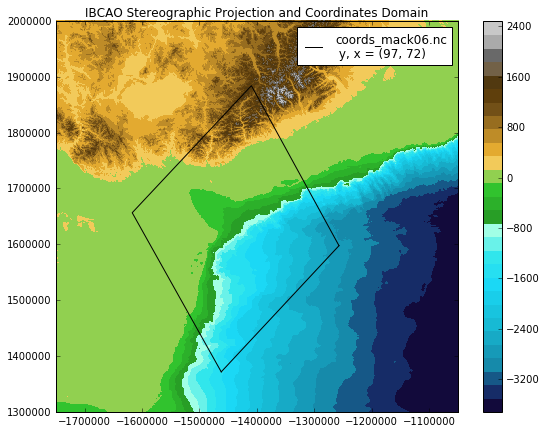

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
cmap, norm = colormap_ibcao.Colormap()
c = ax.pcolorfast(xn, yn, zn, cmap=cmap)
fig.colorbar(c)
ax.plot(lon_stere, lat_stere, 'k', label=filename+'\n y, x = '+str(lon.shape))
ax.plot([lonBL, lonBR],[latBL, latBR], 'k')
ax.legend(); ax.set_title('IBCAO Stereographic Projection and Coordinates Domain')

# Specify domain area

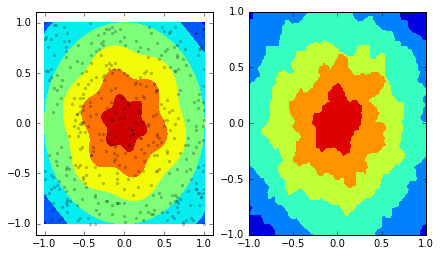

In [9]:
from scipy.interpolate import griddata
def f(x, y):
    s = np.hypot(x, y)
    phi = np.arctan2(y, x)
    tau = s + s*(1-s)/5 * np.sin(6*phi) 
    return 5*(1-tau) + tau

x_test = np.linspace(-1,1,100)
y_test =  np.linspace(-1,1,100)
X_test, Y_test = np.meshgrid(x_test, y_test)
T = f(X_test, Y_test)

npts = 400
px, py = np.random.choice(x_test, npts), np.random.choice(y_test, npts)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(7,4))
ax1.contourf(X_test, Y_test, T)
ax1.scatter(px, py, c='k', alpha=0.2, marker='.')

zz = f(px,py)
Ti = griddata((px, py), zz, (X_test, Y_test), method='nearest')
ax2.contourf(X_test, Y_test, Ti)

In [17]:
tx.shape, px.shape, zz.shape, tX.shape, T.shape, Ti.shape

((100,), (400,), (400,), (100, 100), (100, 100), (100, 100))

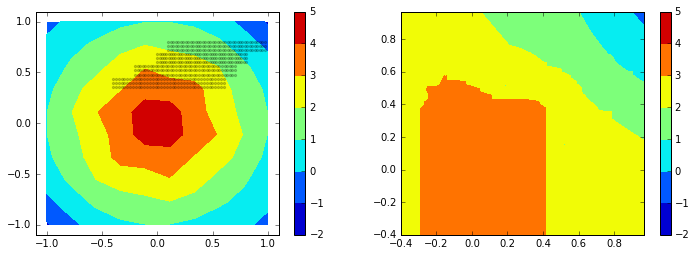

In [16]:
x_full = np.linspace(-1,1,10)
y_full =  np.linspace(-1,1,10)
X_full, Y_full = np.meshgrid(x_full, y_full)
Z_full = f(X_full, Y_full)

x_sub = np.concatenate((np.tile(np.linspace(-0.4,0.6,40),3),
                        np.tile(np.linspace(-0.2,0.7,40),3),
                        np.tile(np.linspace(0,0.8,40),3),
                        np.tile(np.linspace(0.1,0.97,40),3)))
y_sub = np.concatenate((np.ones(40)*0.36, np.ones(40)*0.40,
                        np.ones(40)*0.44, np.ones(40)*0.48, 
                        np.ones(40)*0.52, np.ones(40)*0.56,
                        np.ones(40)*0.60, np.ones(40)*0.64,
                        np.ones(40)*0.68, np.ones(40)*0.72,
                        np.ones(40)*0.76, np.ones(40)*0.80))
z_sub = f(x_sub, y_sub)

x_new = x_sub
y_new = x_sub
X_new, Y_new = np.meshgrid(x_new, y_new)

fig, ax = plt.subplots(1,2,figsize=(12,4))
levels = [-2, -1, 0, 1, 2, 3, 4, 5]
c = ax[0].contourf(X_full, Y_full, Z_full, levels)
fig.colorbar(c, ax=ax[0])
ax[0].scatter(x_sub, y_sub, c='k', s=5, alpha=0.2)

Z_new = griddata((x_sub, y_sub), z_sub, (X_new, Y_new), method='nearest')
c = ax[1].contourf(X_new, Y_new, Z_new, levels)
fig.colorbar(c, ax=ax[1])

In [17]:
x_sub.shape, z_sub.shape, X_new.shape

((480,), (480,), (480, 480))

In [19]:
x_full.shape, z_full.shape, X_sub.shape

((10,), (100,), (480, 480))

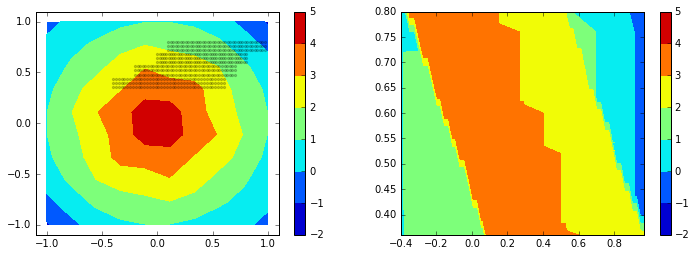

In [27]:
x_full0 = np.linspace(-1,1,10)
y_full0 =  np.linspace(-1,1,10)
X_full, Y_full = np.meshgrid(x_full0, y_full0)
Z_full = f(X_full, Y_full)
z_full = Z_full.ravel()
x_full = np.tile(x_full0,10)
y_full = np.tile(y_full0,10)

x_sub = np.concatenate((np.tile(np.linspace(-0.4,0.6,40),3),
                        np.tile(np.linspace(-0.2,0.7,40),3),
                        np.tile(np.linspace(0,0.8,40),3),
                        np.tile(np.linspace(0.1,0.97,40),3)))
y_sub = np.concatenate((np.ones(40)*0.36, np.ones(40)*0.40,
                        np.ones(40)*0.44, np.ones(40)*0.48, 
                        np.ones(40)*0.52, np.ones(40)*0.56,
                        np.ones(40)*0.60, np.ones(40)*0.64,
                        np.ones(40)*0.68, np.ones(40)*0.72,
                        np.ones(40)*0.76, np.ones(40)*0.80))
X_sub, Y_sub = np.meshgrid(x_sub, y_sub)

fig, ax = plt.subplots(1,2,figsize=(12,4))
levels = [-2, -1, 0, 1, 2, 3, 4, 5]
c = ax[0].contourf(X_full, Y_full, Z_full, levels)
fig.colorbar(c, ax=ax[0])
ax[0].scatter(x_sub, y_sub, c='k', s=5, alpha=0.2)

Z_new = griddata((x_full, y_full), z_full, (X_sub, Y_sub), method='nearest')
c = ax[1].contourf(X_sub, Y_sub, Z_new, levels)
fig.colorbar(c, ax=ax[1])

In [83]:
lons_big.shape, bath_big.shape, lons_canyon.shape

((1960000,), (1960000,), (97, 72))

In [94]:
lons_sub = lons_canyon.ravel()
lats_sub = lats_canyon.ravel()
lons_big0 = xn.ravel()
lats_big0 = yn.ravel()
lons_big = np.tile(lons_big0,1400)
lats_big = np.tile(lats_big0,1400)
bath_big = zn.ravel()

z_test = griddata((lons_big, lats_big), bath_big, (lons_canyon, lats_canyon), method='nearest')

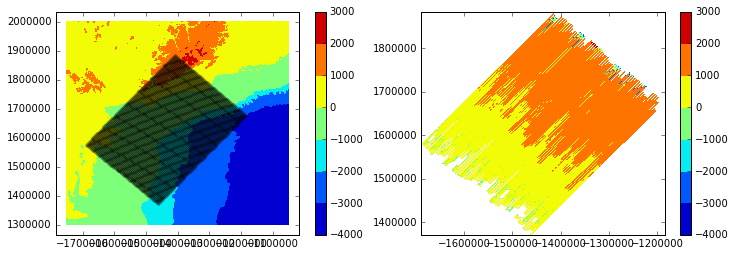

In [95]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
levels = [-4000, -3000, -2000, -1000, 0, 1000, 2000, 3000]
c = ax[0].contourf(xn, yn, zn, levels)
fig.colorbar(c, ax=ax[0])
ax[0].scatter(lons_sub, lats_sub, c='k', s=5, alpha=0.2)

c = ax[1].contourf(lons_canyon, lats_canyon, z_test, levels)
fig.colorbar(c, ax=ax[1])

In [97]:
lons_sub.min()

-1689570.2